# Hand Anomaly Detection Model

In [1]:
import os
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,MaxPooling2D,Flatten,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import  Sequential
from sklearn import metrics

%matplotlib inline

Using TensorFlow backend.


#### For GPU use

In [2]:
# K.tensorflow_backend._get_available_gpus()

In [3]:
# assert len(K.tensorflow_backend._get_available_gpus()) > 0

## Loading the data

In [5]:
hand_df = pd.read_csv('train_hand.csv')
hand_test = pd.read_csv('test_hand.csv')

In [6]:
## Calculating class Weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(hand_df['class_label']), hand_df['class_label'])

## Generating the training, validation, and test data

In [7]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.1)

In [8]:
train_generator = datagen.flow_from_dataframe(
    dataframe = hand_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "training",
    batch_size = 8,
    featurewise_center = True,
    featurewise_std_normalization = True,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe = hand_df,
    directory = None,
    x_col = "path",
    y_col = "class_label",
    subset = "validation",
    batch_size = 8,
    featurewise_center = True,
    featurewise_std_normalization = True,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

Found 4989 validated image filenames belonging to 2 classes.
Found 554 validated image filenames belonging to 2 classes.


In [9]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=hand_test,
directory=None,
x_col="path",
y_col='class_label',
batch_size=8,
shuffle=False,
target_size=(224, 224))

Found 460 validated image filenames belonging to 2 classes.


## MobileNet Model

In [706]:
# Instantiating and customizing the model layers
model = MobileNet()
x = model.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)
x = model.layers[-2].output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [707]:
# Unfreezing layers for training 
for layer in model.layers[:]:
    layer.trainable = True

In [708]:
# Freezing layers for training 
for layer in model.layers[:-2]:
    layer.trainable = False

## Inception V3 model

In [709]:
# input_tensor = Input(shape=(224, 224, 3))
# base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, )

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)

# predictions = Dense(2, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

In [710]:
# for layer in model.layers[:249]:
#    layer.trainable = False

In [711]:
# for layer in model.layers[-5:]:
#    layer.trainable = True

## Compiling the model and training 

In [712]:
model.compile(optimizer=Adam(lr=0.0015, decay=1.0201e-06, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [713]:
model.fit_generator(train_generator, steps_per_epoch=163, 
                    validation_data=valid_generator, 
                    validation_steps=20, 
                    class_weight=class_weights, epochs=10, verbose=1)

Epoch 1/10
163/163 [==============================] - 66s 405ms/step - loss: 0.5820 - acc: 0.7845 - val_loss: 1.2483 - val_acc: 0.0563
Epoch 2/10
163/163 [==============================] - 20s 122ms/step - loss: 0.5201 - acc: 0.7960 - val_loss: 1.1340 - val_acc: 0.0125
Epoch 3/10
163/163 [==============================] - 20s 122ms/step - loss: 0.4953 - acc: 0.8137 - val_loss: 1.1011 - val_acc: 0.0437
Epoch 4/10
163/163 [==============================] - 20s 124ms/step - loss: 0.4899 - acc: 0.8159 - val_loss: 1.1668 - val_acc: 0.0455
Epoch 5/10
163/163 [==============================] - 20s 125ms/step - loss: 0.4938 - acc: 0.8121 - val_loss: 1.3781 - val_acc: 0.0563
Epoch 6/10
163/163 [==============================] - 20s 123ms/step - loss: 0.5114 - acc: 0.7975 - val_loss: 1.3984 - val_acc: 0.0500
Epoch 7/10
163/163 [==============================] - 20s 125ms/step - loss: 0.4956 - acc: 0.8083 - val_loss: 1.3564 - val_acc: 0.0260
Epoch 8/10
163/163 [==============================] - 2

In [10]:
# Get the labels
test_labels = test_generator.classes

In [11]:
with open('flask/models/XR_HAND_mf.json', 'r') as f:
    hand_model = model_from_json(f.read())
# Hand Abnormality detection model weights
    hand_model.load_weights('flask/models/XR_HAND_mf.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Test the model on the test set
Y_pred = hand_model.predict_generator(test_generator, steps=58, verbose=1)

58/58 [==============================] - 38s 661ms/step


In [13]:
matrix = confusion_matrix(test_labels, Y_pred.argmax(axis=1))
matrix

array([[255,  16],
       [126,  63]])

In [14]:
print(metrics.classification_report(test_labels, Y_pred.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.669     0.941     0.782       271
           1      0.797     0.333     0.470       189

    accuracy                          0.691       460
   macro avg      0.733     0.637     0.626       460
weighted avg      0.722     0.691     0.654       460



In [15]:
test_classes = test_generator.class_indices
tc = np.array(list(test_classes.keys()))

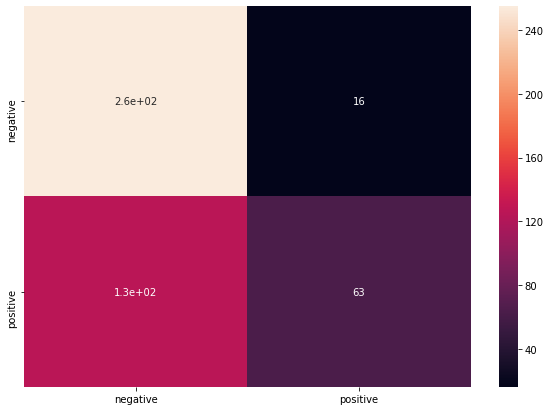

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in tc],
                  columns = [i for i in tc])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [586]:
#Saving the model 
with open('models/XR_Hand.json', 'w') as f:
    f.write(model.to_json())
    
# Saving the model weights
model.save_weights("models/XR_HAND.h5")